1. Acquire appropriate dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/) (script within notebook/collaboratory, using pandas for manipulation), dataset must be different then Wine, Iris, Glass. In order to have easy task, take dataset with categorical attributes (otherwise you must discretize attributes values or make assumption about normality and estimate pdf's)
2. Create function that calculate each class probability
3. Create function that calculate probabilities for given value in each class for each attribute
4. Using bayes rule create classifier that use computed probiabilities functions
5. Evaluate classifier using train/test split (randomize instances, 80% of data as train, 20% as test)
6. Compute evaluation metrics: accuracy, precission, recall, F1-score

In [302]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils.multiclass import unique_labels
from scipy.stats import norm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from classifier_base import ClassifierBase

In [303]:
iris = datasets.load_iris()
X = iris.data
y = iris.target


In [304]:
classes = unique_labels(y)

def get_class_probabilities(y):    
    return {c_name: np.sum(y == c_name) / len(y) for c_name in classes}

y_probs = get_class_probabilities(y)
y_probs

{0: 0.33333333333333331, 1: 0.33333333333333331, 2: 0.33333333333333331}

In [305]:
means = {}

for c in classes:
    means[c] = [np.mean(X[y == c][:, feature]) for feature in range(len(X[0]))]
        
means

{0: [5.0060000000000002, 3.4180000000000001, 1.464, 0.24399999999999999],
 1: [5.9359999999999999,
  2.7700000000000005,
  4.2599999999999998,
  1.3259999999999998],
 2: [6.5879999999999983,
  2.9740000000000002,
  5.5520000000000005,
  2.0260000000000002]}

In [306]:
sigmas = {}

for c in classes:
    sigmas[c] = [np.std(X[y == c][:, feature], ddof=0) for feature in range(len(X[0]))]
    
sigmas

{0: [0.3489469873777391,
  0.37719490982779713,
  0.17176728442867112,
  0.10613199329137281],
 1: [0.5109833656783751,
  0.31064449134018135,
  0.4651881339845203,
  0.19576516544063705],
 2: [0.62948868139149261,
  0.31925538366643091,
  0.54634787452684397,
  0.27188968351153009]}

In [307]:
def get_probability_of_value_given_class(x, feature_index, y_label):
    return norm.pdf(x, loc = means[y_label][feature_index], scale = sigmas[y_label][feature_index])

get_probability_of_value_given_class(3, 1, 0)

0.57236567954624995

In [309]:
x = [5, 3, 1.2, 0.1]

probabilities = {}

for c_label in classes:
    prob = np.prod([get_probability_of_value_given_class(x_i, feature_index=i, y_label=c_label) 
                    for i, x_i in enumerate(x)])
    
    probabilities[c_label] = y_probs[c_label] * prob

    
import operator
max(probabilities.items(), key=operator.itemgetter(1))[0]

0

In [310]:
class NBayes(ClassifierBase):
    def __init__(self):
        self._means = {}
        self._sigmas = {}

        self.y_probabilities = None
        self._features_len = None

    def predict(self, x):
        if type(x) == pd.DataFrame:
            x = x.as_matrix()
        
        return [self._predict_result(x_) for x_ in x]

    def fit(self, X, y):
        super().fit(X, y)

        self._features_len = X.shape[1]

        self.y_probabilities = self._get_class_probabilities()
        self._set_means()
        self._set_sigmas()

    def _predict_result(self, x):
        probabilities = {}
        
        for c_label in self.classes_:
            prob = np.prod([self._get_probability_of_value_given_class(x_i, feature_index=i, y_label=c_label)
                            for i, x_i in enumerate(x)])

            probabilities[c_label] = self.y_probabilities[c_label] * prob

        return max(probabilities.items(), key=operator.itemgetter(1))[0]

    def _get_class_probabilities(self):
        return {c_name: np.sum(self.y_ == c_name) / len(self.y_) for c_name in self.classes_}

    def _get_probability_of_value_given_class(self, x, feature_index, y_label):
        return norm.pdf(x, loc=self._means[y_label][feature_index], scale=self._sigmas[y_label][feature_index])

    def _set_sigmas(self):
        for class_name in self.classes_:
            self._sigmas[class_name] = [np.std(self.X_[self.y_ == class_name][:, feature], ddof=0)
                                        for feature in range(self._features_len)]

    def _set_means(self):
        for class_name in self.classes_:
            self._means[class_name] = [np.mean(self.X_[self.y_ == class_name][:, feature])
                                       for feature in range(self._features_len)]

In [311]:
bayes = NBayes()

from sklearn.naive_bayes import GaussianNB
sklearn_bayes = GaussianNB()

In [312]:
print(f"My GaussianNB : {np.mean(cross_val_score(bayes, X, y, cv=10))}")
print(f"Sklearn GaussianNB : {np.mean(cross_val_score(sklearn_bayes, X, y, cv=10))}")


My GaussianNB : 0.9533333333333334
Sklearn GaussianNB : 0.9533333333333334


In [313]:
banks = pd.read_csv('../datasets/bank.csv', sep=';')
banks.head()

age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

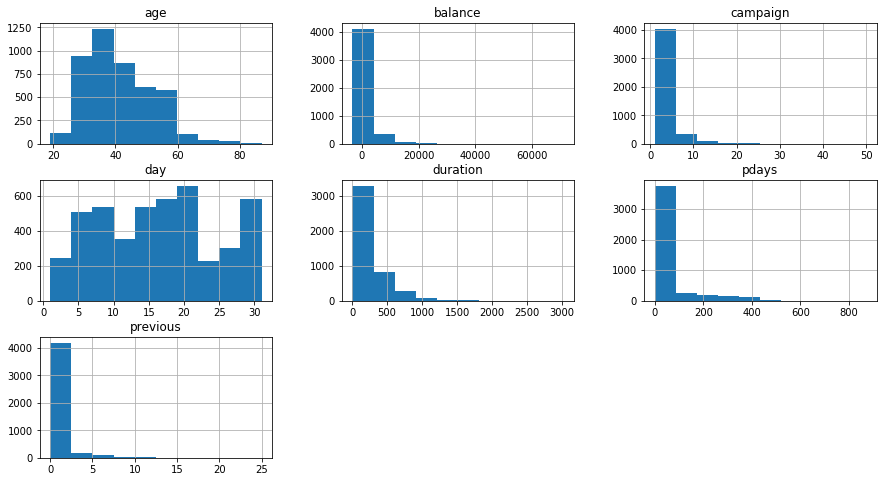

In [314]:
_ = banks.hist(figsize=(15, 8))

In [315]:
banks.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [316]:
banks_cat = banks.copy()

for feature in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']:
    banks[feature] = banks[feature].astype('category')
    banks_cat[feature] = banks[feature].cat.codes

banks_cat.head()

age  job  marital  education  default  balance  housing  loan  contact  \
0   30   10        1          0        0     1787        0     0        0   
1   33    7        1          1        0     4789        1     1        0   
2   35    4        2          2        0     1350        1     0        0   
3   30    4        1          2        0     1476        1     1        2   
4   59    1        1          1        0        0        1     0        2   

   day  month  duration  campaign  pdays  previous  poutcome  y  
0   19     10        79         1     -1         0         3  0  
1   11      8       220         1    339         4         0  0  
2   16      0       185         1    330         1         0  0  
3    3      6       199         4     -1         0         3  0  
4    5      8       226         1     -1         0         3  0

In [325]:
#X = banks_cat[banks.columns[:-1]]
X = banks_cat[['age', 'balance', 'campaign', 'day', 'duration', 'pdays', 'previous']]
y = banks_cat['y']

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

bayes.fit(X_train, y_train)
y_pred = bayes.predict(X_test)

In [352]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precission: ", precision_score(y_test, y_pred, average='micro'))
print("Recall: ", recall_score(y_test, y_pred, average='micro'))
print("F1 micro: ", f1_score(y_test, y_pred, average='micro'))

Accuracy:  0.899447513812
Precission:  0.899447513812
Recall:  0.899447513812
F1 micro:  0.899447513812
